<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session8/Session8_GN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks is all about having a potent classifier for Cifar-10 dataset with the following considerations:
* Make this network: C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11 cN is 1x1 Layer
* Keep the parameter count less than 50000
* Max Epochs is 20
* Use of Group Normalization with DP

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.3 MB/s eta 0:00:00


## Helpers and Utils

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, ExponentialLR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import seaborn as sns
import torch.nn.functional as F

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()

In [6]:
# decorator function to record time exp
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 128
epochs = 20
lr = 1e-3

Random seed set as 42
cuda


In [8]:
class EarlyStopping:

    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=True, delta=1e-5, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = "checkpoint.pt"
        self.trace_func = trace_func
    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Dataloader and pre-processing

In [9]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])


In [10]:
# downloading train and test data
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:06<00:00, 25026878.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

In [13]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [14]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [15]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

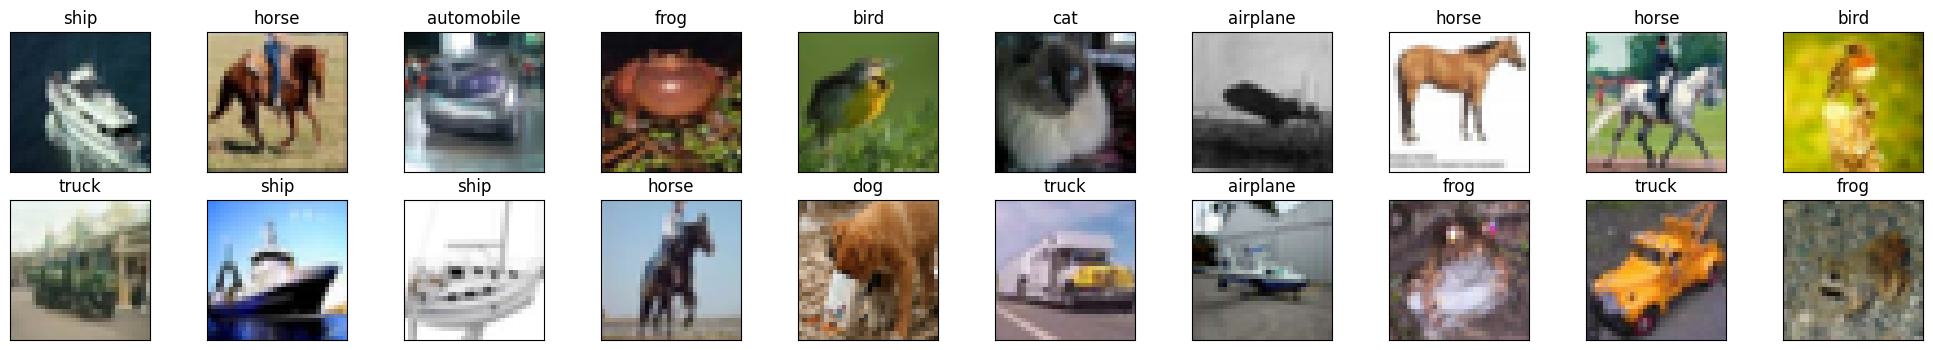

In [16]:
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Model Building and optimization

In [17]:
class Cifar_Baseline_DP(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels, multiplier=1):
    super(Cifar_Baseline_DP, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), # 30,3
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units,  kernel_size=3, stride=1, padding=0), #28,5
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #28,6
         nn.GroupNorm(4,hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #14,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #12,10
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #10,14
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #8,18
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    self.transition2= nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #8,20
         nn.GroupNorm(4,hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #4,20
    )

    self.conv3 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #2,28
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,36
        nn.GroupNorm(4,hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,44
        nn.GroupNorm(4,hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    self.gap = self.gap = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=1, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.transition2(x)
      x = self.conv3(x)
      x = self.gap(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [18]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [19]:
# updated testing modules---
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [20]:
# New Model Instance
baseline_model_1 = Cifar_Baseline_DP(in_channels=3, hidden_units=16, out_channels=10 , multiplier=2).to(device)
summary(baseline_model_1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         GroupNorm-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 32, 28, 28]           9,248
         GroupNorm-6           [-1, 32, 28, 28]              64
              ReLU-7           [-1, 32, 28, 28]               0
           Dropout-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]             528
        GroupNorm-10           [-1, 16, 28, 28]              32
             ReLU-11           [-1, 16, 28, 28]               0
        MaxPool2d-12           [-1, 16, 14, 14]               0
           Conv2d-13           [-1, 32, 12, 12]           4,640
        GroupNorm-14           [-1, 32,

In [21]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_1.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

In [22]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_1, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], baseline_model_1, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 1.94261444529609 Avg Train Metric: 0.21027690829599605: 100%|██████████| 391/391 [00:20<00:00, 18.81it/s]


Function Took 20.7923 seconds


Avg Test Loss: 1.7317936344991756 Avg Test Metric: 0.3716323866119868: 100%|██████████| 79/79 [00:02<00:00, 27.01it/s]


Function Took 2.9329 seconds
Validation loss decreased (inf --> 1.731794).  Saving model ...
Epoch 1


Avg Train Loss: 1.6128070394096472 Avg Train Metric: 0.38481832663421434: 100%|██████████| 391/391 [00:20<00:00, 18.94it/s]


Function Took 20.6502 seconds


Avg Test Loss: 1.5153182684620725 Avg Test Metric: 0.45642257453520085: 100%|██████████| 79/79 [00:02<00:00, 26.71it/s]


Function Took 2.9670 seconds
Validation loss decreased (1.731794 --> 1.515318).  Saving model ...
Epoch 2


Avg Train Loss: 1.4747515621087741 Avg Train Metric: 0.4539108141456419: 100%|██████████| 391/391 [00:21<00:00, 18.22it/s]


Function Took 21.4654 seconds


Avg Test Loss: 1.388153331189216 Avg Test Metric: 0.4860141420666176: 100%|██████████| 79/79 [00:03<00:00, 25.87it/s]


Function Took 3.0624 seconds
Validation loss decreased (1.515318 --> 1.388153).  Saving model ...
Epoch 3


Avg Train Loss: 1.360280762243149 Avg Train Metric: 0.5074937480032596: 100%|██████████| 391/391 [00:21<00:00, 18.53it/s]


Function Took 21.1053 seconds


Avg Test Loss: 1.3562674371502068 Avg Test Metric: 0.501053192192995: 100%|██████████| 79/79 [00:03<00:00, 23.75it/s]


Function Took 3.3352 seconds
Validation loss decreased (1.388153 --> 1.356267).  Saving model ...
Epoch 4


Avg Train Loss: 1.27713429638187 Avg Train Metric: 0.5358790143981309: 100%|██████████| 391/391 [00:20<00:00, 19.35it/s]


Function Took 20.2106 seconds


Avg Test Loss: 1.2292439077473893 Avg Test Metric: 0.5583467076096353: 100%|██████████| 79/79 [00:03<00:00, 19.93it/s]


Function Took 3.9722 seconds
Validation loss decreased (1.356267 --> 1.229244).  Saving model ...
Epoch 5


Avg Train Loss: 1.1949327703936936 Avg Train Metric: 0.5690166098077584: 100%|██████████| 391/391 [00:21<00:00, 17.91it/s]


Function Took 21.8442 seconds


Avg Test Loss: 1.1683506143244007 Avg Test Metric: 0.5955792122249361: 100%|██████████| 79/79 [00:04<00:00, 19.56it/s]


Function Took 4.0458 seconds
Validation loss decreased (1.229244 --> 1.168351).  Saving model ...
Epoch 6


Avg Train Loss: 1.1370961321589281 Avg Train Metric: 0.5964374211438171: 100%|██████████| 391/391 [00:19<00:00, 19.55it/s]


Function Took 20.0044 seconds


Avg Test Loss: 1.0784369043157072 Avg Test Metric: 0.6218087544924096: 100%|██████████| 79/79 [00:03<00:00, 24.74it/s]


Function Took 3.2020 seconds
Validation loss decreased (1.168351 --> 1.078437).  Saving model ...
Epoch 7


Avg Train Loss: 1.0983450056037025 Avg Train Metric: 0.6133801414228767: 100%|██████████| 391/391 [00:20<00:00, 18.74it/s]


Function Took 20.8751 seconds


Avg Test Loss: 1.0277881773212287 Avg Test Metric: 0.6366014314603202: 100%|██████████| 79/79 [00:03<00:00, 25.05it/s]


Function Took 3.1648 seconds
Validation loss decreased (1.078437 --> 1.027788).  Saving model ...
Epoch 8


Avg Train Loss: 1.05472696406762 Avg Train Metric: 0.6261849045143713: 100%|██████████| 391/391 [00:20<00:00, 18.73it/s]


Function Took 20.8766 seconds


Avg Test Loss: 1.0262983260275442 Avg Test Metric: 0.6346090036102489: 100%|██████████| 79/79 [00:03<00:00, 25.97it/s]


Function Took 3.0535 seconds
Validation loss decreased (1.027788 --> 1.026298).  Saving model ...
Epoch 9


Avg Train Loss: 1.0254273102106646 Avg Train Metric: 0.6376701675717483: 100%|██████████| 391/391 [00:21<00:00, 18.54it/s]


Function Took 21.1023 seconds


Avg Test Loss: 1.0026923342596126 Avg Test Metric: 0.6501678152929379: 100%|██████████| 79/79 [00:03<00:00, 26.30it/s]


Function Took 3.0124 seconds
Validation loss decreased (1.026298 --> 1.002692).  Saving model ...
Epoch 10


Avg Train Loss: 0.99903549196775 Avg Train Metric: 0.6490442668995284: 100%|██████████| 391/391 [00:21<00:00, 18.41it/s]


Function Took 21.2531 seconds


Avg Test Loss: 0.9753492625453805 Avg Test Metric: 0.6603573387182211: 100%|██████████| 79/79 [00:03<00:00, 25.72it/s]


Function Took 3.0817 seconds
Validation loss decreased (1.002692 --> 0.975349).  Saving model ...
Epoch 11


Avg Train Loss: 0.9747837812394438 Avg Train Metric: 0.6556529401208434: 100%|██████████| 391/391 [00:21<00:00, 18.38it/s]


Function Took 21.2773 seconds


Avg Test Loss: 0.9292968873736225 Avg Test Metric: 0.6749904548065572: 100%|██████████| 79/79 [00:04<00:00, 19.08it/s]


Function Took 4.1507 seconds
Validation loss decreased (0.975349 --> 0.929297).  Saving model ...
Epoch 12


Avg Train Loss: 0.9601015192468453 Avg Train Metric: 0.6655354990678675: 100%|██████████| 391/391 [00:20<00:00, 19.10it/s]


Function Took 20.4754 seconds


Avg Test Loss: 0.9091766461541381 Avg Test Metric: 0.6791980598546281: 100%|██████████| 79/79 [00:03<00:00, 20.37it/s]


Function Took 3.8886 seconds
Validation loss decreased (0.929297 --> 0.909177).  Saving model ...
Epoch 13


Avg Train Loss: 0.9395519911175798 Avg Train Metric: 0.6697172803037307: 100%|██████████| 391/391 [00:19<00:00, 19.65it/s]


Function Took 19.9024 seconds


Avg Test Loss: 0.9155316511286965 Avg Test Metric: 0.6794880741759192: 100%|██████████| 79/79 [00:03<00:00, 21.04it/s]


Function Took 3.7647 seconds
EarlyStopping counter: 1 out of 3
Epoch 14


Avg Train Loss: 0.9165427587221345 Avg Train Metric: 0.6815096706990391: 100%|██████████| 391/391 [00:20<00:00, 19.23it/s]


Function Took 20.3477 seconds


Avg Test Loss: 0.9290788460381424 Avg Test Metric: 0.6716547442387931: 100%|██████████| 79/79 [00:03<00:00, 25.81it/s]


Function Took 3.0692 seconds
EarlyStopping counter: 2 out of 3
Epoch 15


Avg Train Loss: 0.9009877246664003 Avg Train Metric: 0.683412948685229: 100%|██████████| 391/391 [00:21<00:00, 18.09it/s]


Function Took 21.6225 seconds


Avg Test Loss: 0.8964813434624974 Avg Test Metric: 0.6924502623232105: 100%|██████████| 79/79 [00:04<00:00, 16.62it/s]


Function Took 4.7681 seconds
Validation loss decreased (0.909177 --> 0.896481).  Saving model ...
Epoch 16


Avg Train Loss: 0.8906259446802651 Avg Train Metric: 0.6906206868493648: 100%|██████████| 391/391 [00:24<00:00, 16.04it/s]


Function Took 24.3896 seconds


Avg Test Loss: 0.8872514646264571 Avg Test Metric: 0.68619443796858: 100%|██████████| 79/79 [00:04<00:00, 19.75it/s]


Function Took 4.0098 seconds
Validation loss decreased (0.896481 --> 0.887251).  Saving model ...
Epoch 17


Avg Train Loss: 0.8773678330814138 Avg Train Metric: 0.6941235941999099: 100%|██████████| 391/391 [00:20<00:00, 19.13it/s]


Function Took 20.4427 seconds


Avg Test Loss: 0.857981247237966 Avg Test Metric: 0.7042338584042802: 100%|██████████| 79/79 [00:04<00:00, 18.72it/s]


Function Took 4.2245 seconds
Validation loss decreased (0.887251 --> 0.857981).  Saving model ...
Epoch 18


Avg Train Loss: 0.8578821262130347 Avg Train Metric: 0.7011363698393488: 100%|██████████| 391/391 [00:20<00:00, 19.05it/s]


Function Took 20.5294 seconds


Avg Test Loss: 0.8371528024914898 Avg Test Metric: 0.705442998982683: 100%|██████████| 79/79 [00:03<00:00, 25.36it/s]


Function Took 3.1233 seconds
Validation loss decreased (0.857981 --> 0.837153).  Saving model ...
Epoch 19


Avg Train Loss: 0.8473321175026467 Avg Train Metric: 0.7066686638175984: 100%|██████████| 391/391 [00:21<00:00, 18.53it/s]


Function Took 21.1028 seconds


Avg Test Loss: 0.9264300865463063 Avg Test Metric: 0.6853387287900418: 100%|██████████| 79/79 [00:03<00:00, 25.66it/s]

Function Took 3.0885 seconds
EarlyStopping counter: 1 out of 3


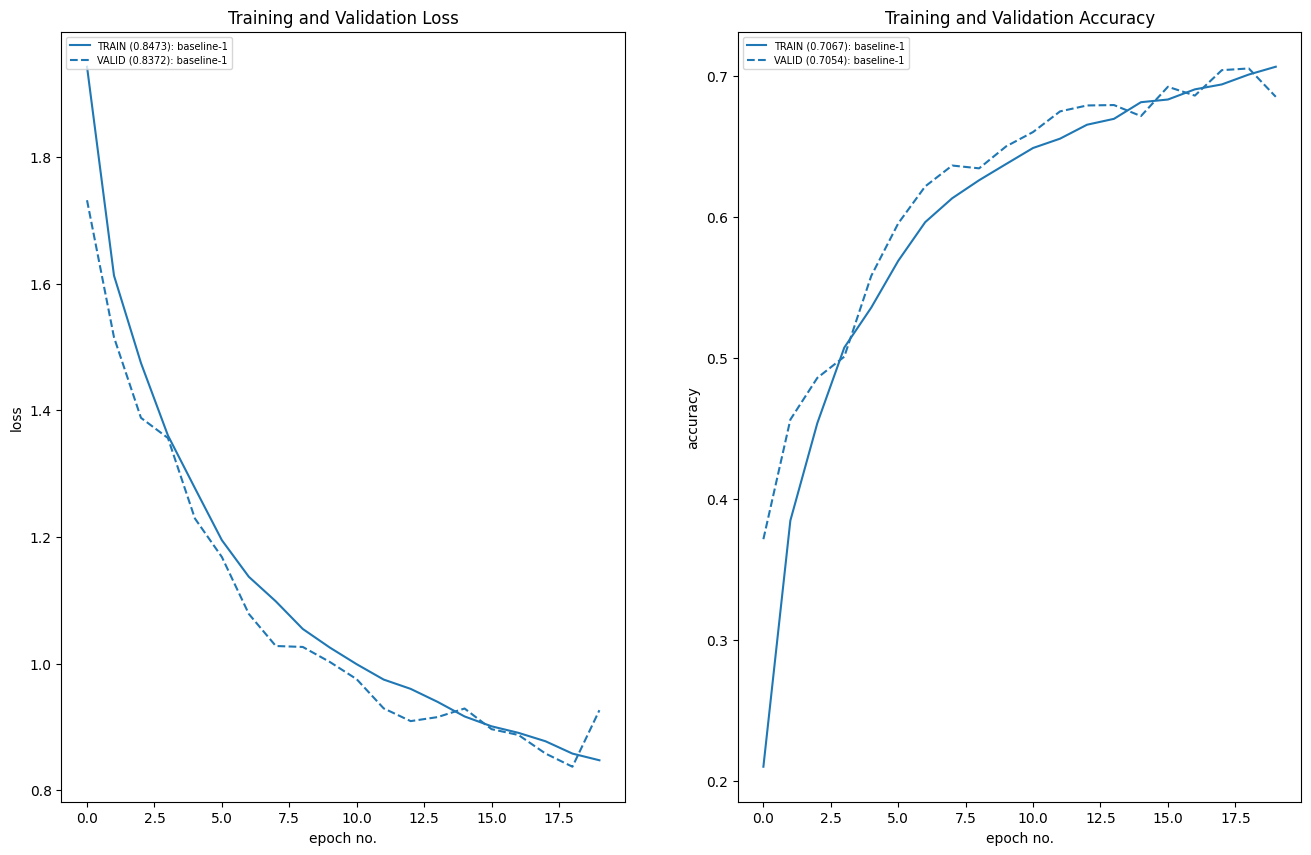

In [24]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-1'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

## Eval Framework and Metrics

In [26]:
def eval_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                ):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  predictions = []
  actuals = []

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      actuals.append(label)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      # metric calc
      preds = torch.argmax(preds,dim=1)

      predictions.append(preds)

  return torch.cat(actuals, dim=0).cpu().numpy(), torch.cat(predictions, dim=0).cpu().numpy()

In [27]:
eval_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
actuals , predictions = eval_module(baseline_model_1, device, eval_loader)

100%|██████████| 79/79 [00:06<00:00, 11.67it/s]


In [28]:
min(actuals),max(actuals)

(0, 9)

## Metrics

In [29]:
cmatrix = confusion_matrix(actuals, predictions)
print(classification_report(actuals, predictions, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.75      0.59      0.66      1000
  automobile       0.88      0.82      0.85      1000
        bird       0.68      0.46      0.55      1000
         cat       0.46      0.47      0.46      1000
        deer       0.72      0.58      0.64      1000
         dog       0.56      0.69      0.62      1000
        frog       0.78      0.77      0.78      1000
       horse       0.77      0.71      0.74      1000
        ship       0.63      0.93      0.75      1000
       truck       0.74      0.86      0.80      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



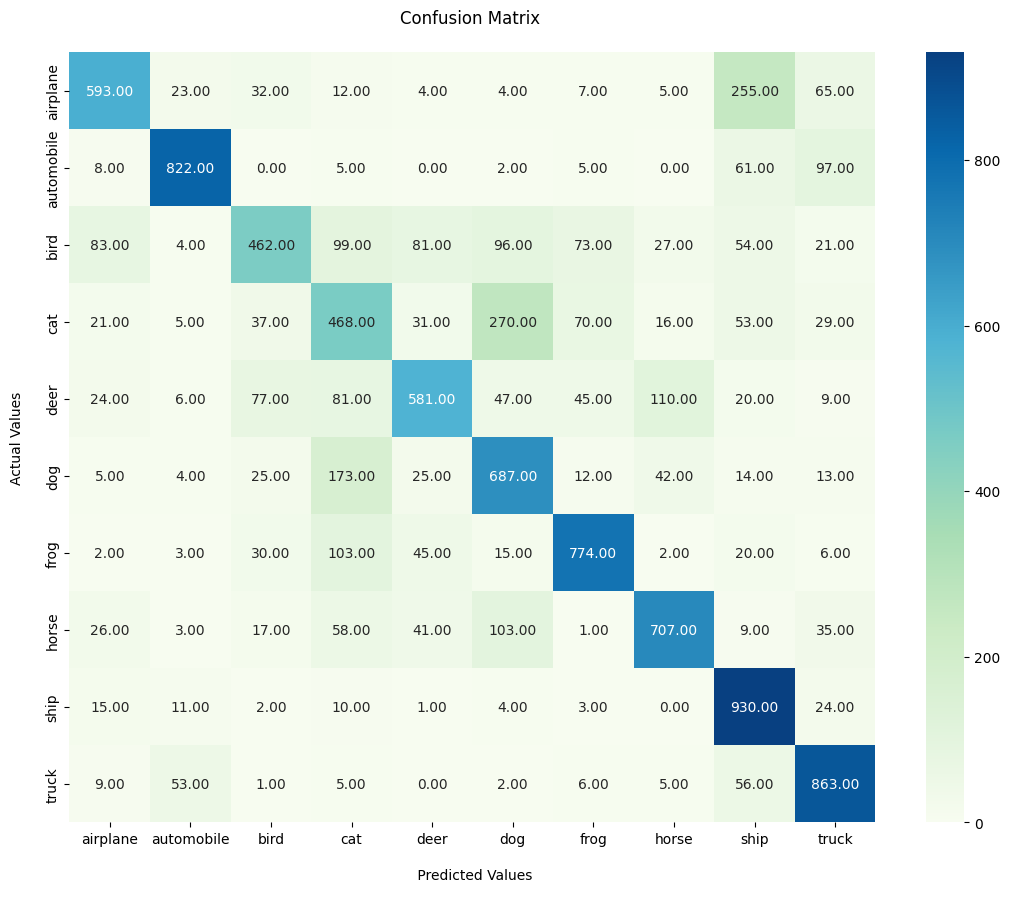

In [30]:
plt.figure(figsize=(13,10))
fx=sns.heatmap(cmatrix, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(classes)
fx.yaxis.set_ticklabels(classes)
plt.show()

In [31]:
mismatches = np.where(predictions != actuals)

In [32]:
# idx = mismatches[0][0]
# print(f'Actual: {classes[actuals[idx]]}')
# print(f'Predicted: {classes[predictions[idx]]}')

Label: frog and Prediction: cat


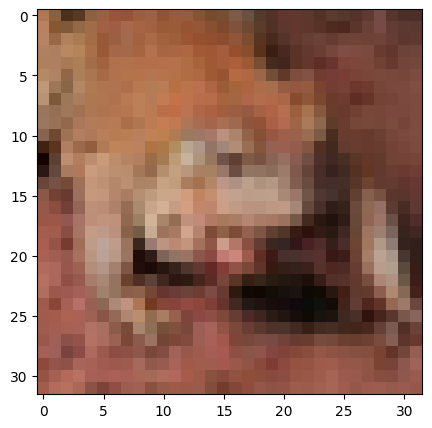

Label: automobile and Prediction: truck


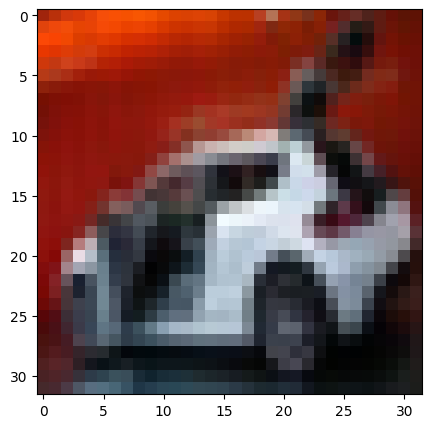

Label: cat and Prediction: dog


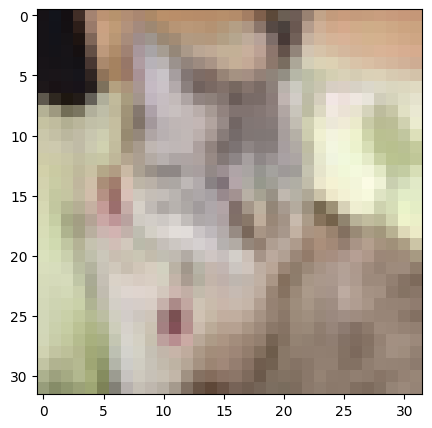

Label: automobile and Prediction: truck


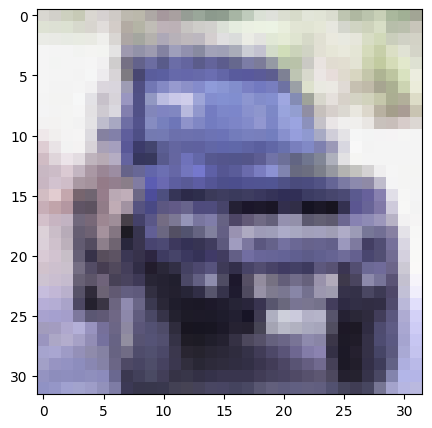

Label: airplane and Prediction: cat


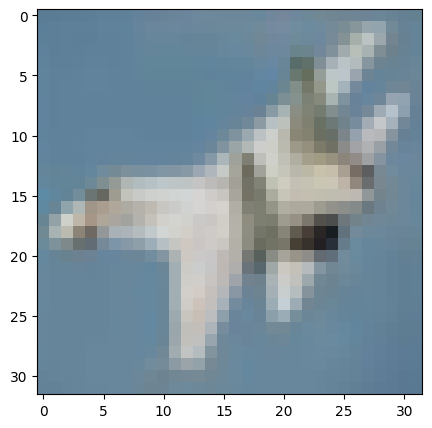

Label: ship and Prediction: frog


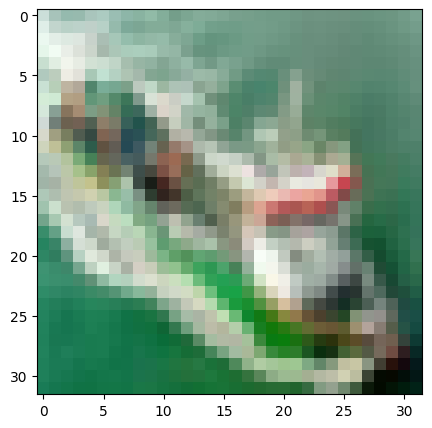

Label: horse and Prediction: dog


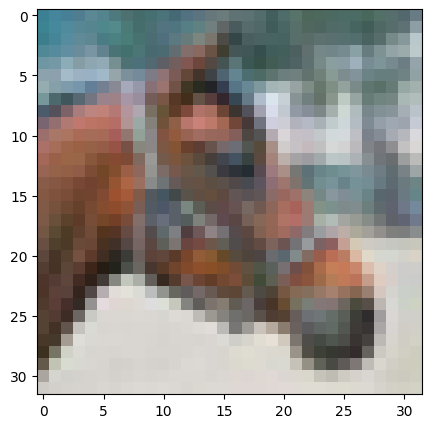

Label: deer and Prediction: airplane


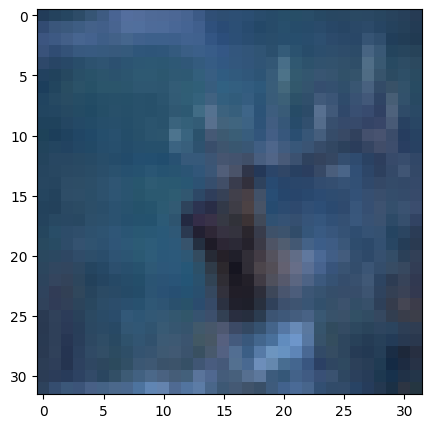

Label: dog and Prediction: bird


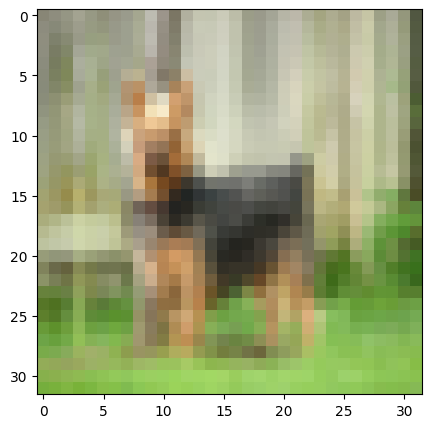

Label: bird and Prediction: cat


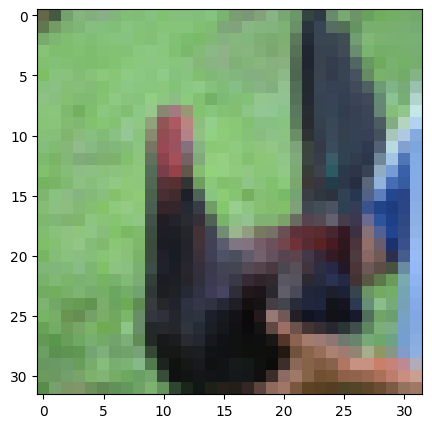

In [33]:
for idx in mismatches[0][:10]:
  plt.figure(figsize=(5,5))
  img, label = test[idx]
  imshow(img)
  print(f'Label: {classes[label]} and Prediction: {classes[predictions[idx]]}')
  plt.show()

Sumamry:

- The model used is a Cifar_Baseline, which is a convolutional neural network with three convolution blocks, each followed by a transition block.
- The model achieved a training accuracy of 70% and a validation accuracy of 70%.
- The model's training loss was 0.84 and its validation loss was 0.83.
- The model's confusion matrix showed that it was most accurate at classifying Autombile and least accurate at classifying Cats.
- Early stopping was triggered after N epochs due to lack of improvement in validation loss.
- Addition of Dropouts makes a significant difference in terms of overfitting.

## Links:
https://medium.com/@zljdanceholic/groupnorm-then-batchnorm-instancenorm-layernorm-e2b2a1d350a0
https://wandb.ai/wandb_fc/Normalization/reports/Normalization-Series-What-is-Batch-Norm---VmlldzoxMjk2ODcz
https://wandb.ai/wandb_fc/GroupNorm/reports/Group-Normalization-in-Pytorch-With-Examples---VmlldzoxMzU0MzMy
https://wandb.ai/wandb_fc/LayerNorm/reports/Layer-Normalization-in-Pytorch-With-Examples---VmlldzoxMjk5MTk1
https://wandb.ai/wandb_fc/Normalization-Series/reports/Instance-Normalization-in-PyTorch-With-Examples---VmlldzoxNDIyNTQx